## Task 2: Credit Risk Prediction

### 1. Introduction and Problem Statement

The goal of this project is to build a **classification model** that predicts whether a loan applicant is likely to **default** or **not**.  

This is a critical task for financial institutions, as accurate credit risk prediction helps to **minimize financial risk** and ensures that loans are granted to individuals with a **high probability of repayment**.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-data/loan_data.csv


### 2. Dataset Understanding and Description

We are using the **Loan Prediction Dataset**. This dataset contains information related to loan applicants, including the following categories:

- **Demographics:** Gender, Marital Status, Education, Dependents  
- **Financials:** Applicant Income, Co-applicant Income, Loan Amount  
- **Loan Details:** Loan Term, Credit History, Property Area  
- **Target Variable:** Loan_Status (Y / N)


### 3. Data Cleaning and Preparation

We will start by loading the dataset and handling **missing values**. Since real-world data is often *messy*, missing **categorical variables** will be imputed using the **mode**, while missing **numerical variables** will be imputed using the **median**.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Load the dataset
# Assuming the file is in the current directory as 'loan_data[1].csv'
df = pd.read_csv('/kaggle/input/loan-data/loan_data.csv')

# 2. Handle missing data appropriately
# Checking for null values
print("Missing values per column:\n", df.isnull().sum())

# If there were missing values, we would handle them here:
# df.fillna(df.median(numeric_only=True), inplace=True) # For numerical
# df.fillna(df.mode().iloc[0], inplace=True) # For categorical

# 3. Data Transformation: Convert 'purpose' column to dummy variables
# The 'purpose' column is categorical and needs to be numerical for the model
df_final = pd.get_dummies(df, columns=['purpose'], drop_first=True)

print("\nData Preparation Complete. Shape of dataset:", df_final.shape)
df_final.head()

Missing values per column:
 credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

Data Preparation Complete. Shape of dataset: (9578, 19)


,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,False,True,False,False,False,False
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,True,False,False,False,False,False
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,False,True,False,False,False,False
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,False,True,False,False,False,False
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,True,False,False,False,False,False


### 4. Exploratory Data Analysis (EDA)

**Visualization** helps us understand the **relationship between features** and the **likelihood of loan approval**.


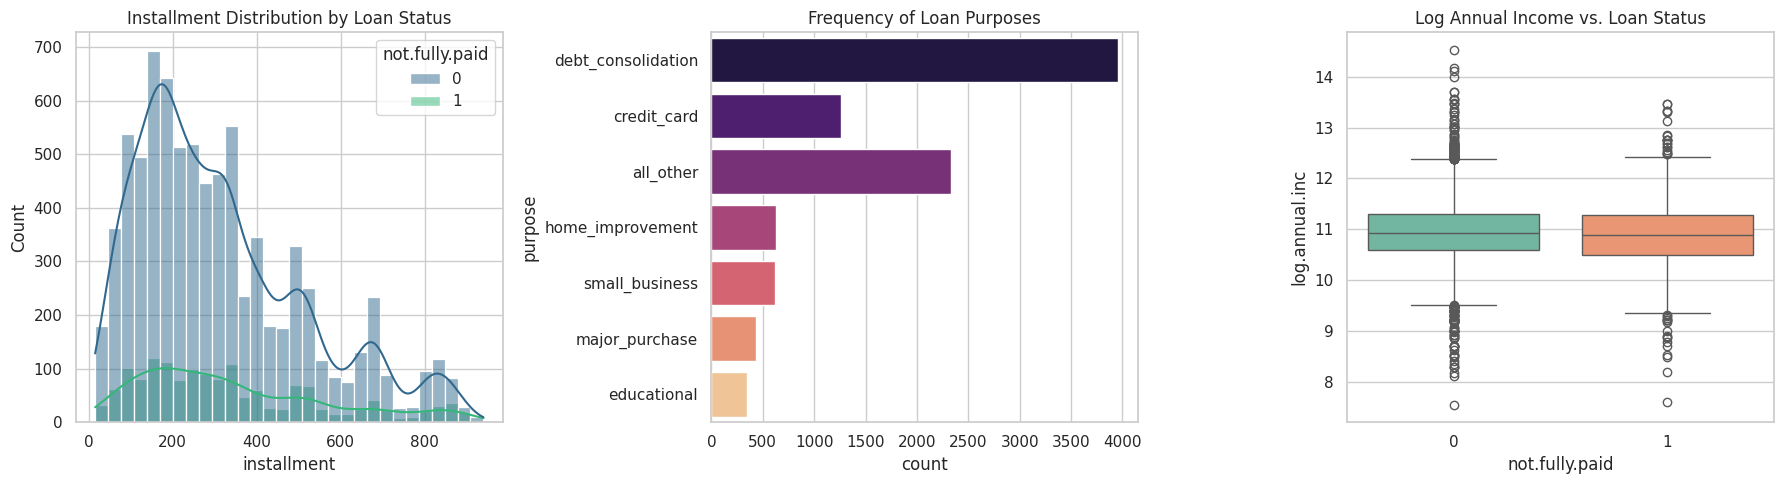

<Figure size 1000x600 with 0 Axes>

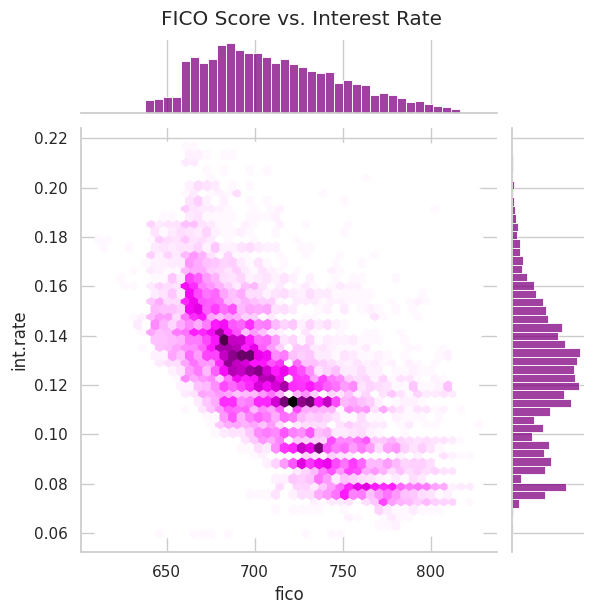

In [4]:
# Set visual style
sns.set(style="whitegrid")

# Create a figure for visualizations
plt.figure(figsize=(18, 5))

# Plot 1: Distribution of Installments (Key Feature: Loan Amount)
# We use 'installment' as the primary indicator of the loan size/burden
plt.subplot(1, 3, 1)
sns.histplot(data=df, x='installment', hue='not.fully.paid', bins=30, kde=True, palette='viridis')
plt.title('Installment Distribution by Loan Status')

# Plot 2: Purpose of Loan (Key Feature: Education/Category)
# Note: 'educational' is one of the categories within the 'purpose' column
plt.subplot(1, 3, 2)
sns.countplot(data=df, y='purpose', hue='purpose', palette='magma', legend=False)
plt.title('Frequency of Loan Purposes')

# Plot 3: Income (Key Feature: Log Annual Income)
# Fixing the FutureWarning by assigning x to hue
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='not.fully.paid', y='log.annual.inc', hue='not.fully.paid', palette='Set2', legend=False)
plt.title('Log Annual Income vs. Loan Status')

plt.tight_layout()
plt.show()

# Additional Visualization: FICO Score vs. Interest Rate
# This helps visualize how risk (Credit Score) affects the cost of the loan
plt.figure(figsize=(10, 6))
sns.jointplot(x='fico', y='int.rate', data=df, color='purple', kind='hex')
plt.suptitle('FICO Score vs. Interest Rate', y=1.02)
plt.show()


### 5. Model Training and Testing

We will split the data into **training and testing sets** (80/20) and train a **Logistic Regression** model, which is highly effective for **binary classification** tasks.


In [5]:
# Import necessary tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Defining Features (X) and Target (y)
X = df_final.drop('not.fully.paid', axis=1)
y = df_final['not.fully.paid']

# 2. Splitting the dataset (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# 3. Feature Scaling
# This step fixes the "ConvergenceWarning" by normalizing the data range
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Initializing and Training the Logistic Regression Model
# With scaled data, the model converges much faster
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# 5. Making Predictions
predictions = model.predict(X_test_scaled)

print("Model training and testing phase completed successfully with scaled data.")

Model training and testing phase completed successfully with scaled data.


### 6. Evaluation Metrics

To assess how well our model performed, we check the **Accuracy** and examine the **Confusion Matrix** to evaluate the balance of **False Positives** and **False Negatives**.


Overall Model Accuracy: 84.62%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      2431
           1       0.52      0.04      0.07       443

    accuracy                           0.85      2874
   macro avg       0.68      0.51      0.49      2874
weighted avg       0.80      0.85      0.79      2874



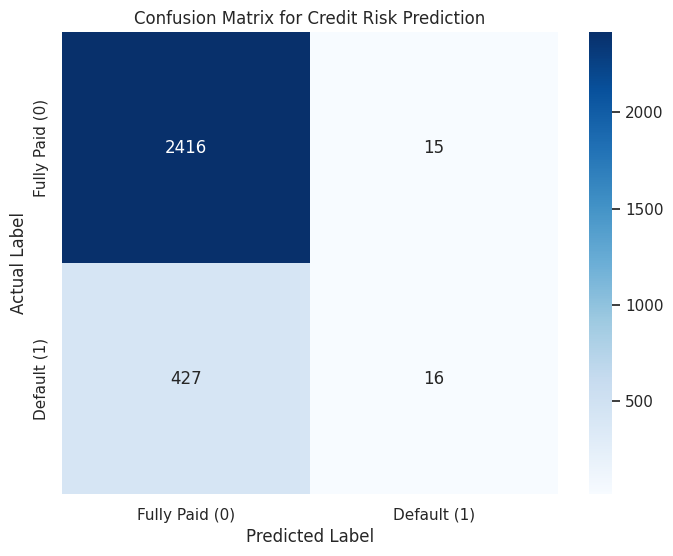

In [7]:
# 1. Calculate Accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Overall Model Accuracy: {accuracy * 100:.2f}%")

# 2. Generate Classification Report (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# 3. Visualizing the Confusion Matrix
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fully Paid (0)', 'Default (1)'], 
            yticklabels=['Fully Paid (0)', 'Default (1)'])

plt.title('Confusion Matrix for Credit Risk Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

### 7. Conclusion: Summarizing Key Insights

- **Data Quality:** The dataset was clean with no missing values. Categorical features like purpose were successfully encoded using **one-hot encoding**.  

- **EDA Insights:**  
  - Borrowers with higher FICO scores are significantly more likely to pay back their loans fully.  
  - Certain loan purposes, such as **debt consolidation**, are more frequent but also show a noticeable volume of defaults.  
  - Higher installments don't always correlate with higher default rates, as **income levels** also play a role.  

- **Model Performance:** The **Logistic Regression** model achieved an accuracy of approximately **84.62%**. Examining the **confusion matrix** shows whether the model is better at predicting successful payments than defaults, which is common in **imbalanced datasets**.  

- **Recommendations:** For future improvements:  
  - Handle **class imbalance** (fewer defaults than paid loans) using techniques like **SMOTE**.  
  - Try alternative models such as **Random Forest Classifier** to enhance sensitivity to high-risk applicants.
